# Streetscapes workspaces

This notebook illustrates how to use project workspaces in Streetscapes. You can load different data sources and ML models, process streetview images and save generated data to your workspace.

This notebook includes the following steps:

- [Define a workspace](#1---define-a-workspace)
- [Subset data](#2---subset-data)
- [Visualise data](#3---visualise-data)
- [Download images](#4---download-images)
- [Segment images](#5---segment-images)
- [Calculate statistics](#6---calculate-statistics)
- [Rasterise data](#7---rasterise-data)

### 0 - Libraries

In [1]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import ibis

ibis.options.interactive = True

# --------------------------------------
from streetscapes.models import ModelType
from streetscapes.sources import SourceType
from streetscapes.streetview import SVWorkspace

### 1 - Define a workspace

Streetscapes has a workspace functionality to facilitate data analysis. Within this workspace, downloaded data, images, segmented masks and analysis for a certain project are self contained and reproducible. 

<span style="color:grey;"><i> Note: You can also pass the path to an `.env` file containing configuration options for the workspace. By default, the workspace looks for an `.env` file inside the workspace directory, and if it doesn't exist, it walks the parent tree until it finds one or it reaches the root of the file system. Environment variables are also recognised automatically.</i></span>

First, create a workspace or load an existing one. In this tutorial, we will be doing an analysis of Amsterdam, so we are naming our workspace "Amsterdam":

In [2]:
ws = SVWorkspace("./Amsterdam", create=True)

Let's now look at where this new workspace is located:

In [43]:
workspace_path = ws.get_workspace_path("")
workspace_path

PosixPath('/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/tutorials/Amsterdam')

Now let's add which source of images we would like to use. Possible are sources are: [Mapillary](https://www.mapillary.com/), [Kartaview](https://kartaview.org/), [Google Streetview](https://developers.google.com/maps/documentation/streetview) and [Amsterdam Open Panorama](https://amsterdam.github.io/projects/open-panorama/). It is also possible to use [Global Streetscapes](https://ual.sg/project/global-streetscapes/) as a data source. 

In this example, we will use Global Streetscapes, Kartaview and Mapillary. 

<span style="color:red;">NOTE</span>: Make sure you have the appropriate API keys stored in your `.env` file. 

In [3]:
gss = ws.add_source(SourceType.GlobalStreetscapes)
kv = ws.add_source(SourceType.KartaView)
mp = ws.add_source(SourceType.Mapillary)

In [4]:
gss, kv, mp

(GlobalStreetscapesSource(root_dir='~/.cache/huggingface/hub/datasets--NUS-UAL--global-streetscapes'),
 KartaViewSource(root_dir='~/.cache/huggingface/assets/streetscapes/images/karta_view'),
 MapillarySource(root_dir='~/.cache/huggingface/assets/streetscapes/images/mapillary'))

If we show the contents of the workspace directory, we can see that a subdirectory for Amsterdam was created as well as a [duckdb](https://duckdb.org/) metadata file.

In [5]:
ws.show_contents()

Amsterdam/
└─metadata.db


To test that the connection to our data sources work, we can get the image URLs for a KartaView and a Mapillary image:

In [7]:
kv_img_url = kv.get_image_url(1208524)
kv_img_url

'https://storage2.openstreetcam.org/files/photo/2016/5/5/proc/3823_3446d_572b6b13bdfca.jpg'

In [8]:
mp_img_url = mp.get_image_url("4911230068985425")
mp_img_url

'https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/An--rrF4WlM05JH5SMiWxbdSXVWL0mFEymquJWW0EmSjaBemmKBcF8DRGqIe8akNayRiH0VTYunIfeHZlt2zAGA0sYkEkeWIUtnfp27cgiCen37fra1_v0gwTJFgNL5wTiUGkS7F56f_yLBZF1HqZg?edm=ALXxkZ8EAAAA&_nc_gid=zLNLzcXYogHk3_sBJrLoKw&_nc_oc=Adlk1Ytp0_t8q0_QGDMAdBwDaj8inl9berIDJZNu1Pixpm_zyqxvVBPRWooExKT2r7g&ccb=10-5&oh=00_AfEZfb5-EM7SuzjX57cNSkZ56geGtoCC_rhcQP40sig6NQ&oe=6831983C&_nc_sid=201bca'

### 2 - Subset data

Let's have a more detailed look into the data sources that we have loaded. Starting with the `Global Streetscapes` source, let's see how we can load and manipulate subsets of the available data. First, show the contents of the root directory for the `Global Streetscapes` source.

In [9]:
gss.show_contents()

datasets--NUS-UAL--global-streetscapes/
├─info.csv
├─data/
│ └─parquet/
│   └─streetscapes.parquet
└─.cache/
  └─huggingface/
    ├─.gitignore
    └─download/
      ├─info.csv.lock
      ├─info.csv.metadata
      └─data/
        └─parquet/
          ├─streetscapes.parquet.metadata
          └─streetscapes.parquet.lock


Load and display information from the `info.csv` file from the `Global Streetscapes` source. All datasets below are Ibis tables, which makes subsetting and filtering extremely fast.

In [44]:
info = gss.load_csv("info", gss.root_dir)
info.head()

┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ column0 ┃ Filename    ┃ Overview                                                                ┃ Notes                                                                            ┃ Field              ┃ Format ┃ Explanation                                                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64   │ string      │ string                                                                  │ string                                                                           │ string             │ string │ string                                                          │
├─────────┼─────────────┼─────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────────┼────────┼─────────────────────────────────────────────────────────────────┤
│       1 │ climate.csv │ Contains the Koppen climate zone associated with each image's location. │ The calculation is as accurate as the location of the image given by the source… │ uuid               │ string │ Universally Unique IDentifier, unique for every image           │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ source             │ string │ Source of the image, either Mapillary or KartaView              │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ orig_id            │ int    │ Original ID of the image as specified by Mapillary or KartaView │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ koppen_geiger_zone │ string │ A zone code to identify the Koppen climate zone                 │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ zone_description   │ string │ Short description of the climate zone                           │
└─────────┴─────────────┴─────────────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────────────────────┴────────────────────┴────────┴─────────────────────────────────────────────────────────────────┘

Load the entire `streetscapes.parquet` set from `Global Streetscapes`. We don't need to specify the `.parquet` extension since we are using the `load_parquet()` method.

In [12]:
streetscapes = gss.load_parquet("streetscapes")
streetscapes.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id         ┃ glare   ┃ lighting_condition ┃ pano_status ┃ platform        ┃ quality       ┃ reflection ┃ view_direction ┃ weather ┃ lat        ┃ lon        ┃ datetime_local          ┃ year  ┃ month ┃ day   ┃ hour  ┃ width   ┃ height  ┃ heading    ┃ projection_type ┃ hFoV      ┃ vFoV      ┃ sequence_index ┃ sequence_id            ┃ sequence_img_count ┃ Bird    ┃ Ground-Animal ┃ Curb    ┃ Fence    ┃ Guard-Rail ┃ Barrier ┃ Wall    ┃ Bike-Lane ┃ Crosswalk---Plain ┃ Curb-Cut ┃ Parking ┃ Pedestrian-Area ┃ Rail-Track ┃ Road         ┃ Service-Lane ┃ Sidewalk ┃ Bridge   ┃ Building ┃ Tunnel  ┃ Person  ┃ Bicyclist ┃ Motorcyclist ┃ Other-Rider ┃ Lane-Marking---Crosswalk ┃ Lane-Marking---General ┃ Mountain ┃ Sand    ┃ Sky          ┃ Snow    ┃ Terrain  ┃ Vegetation   ┃ Water   ┃ Banner  ┃ Bench   ┃ Bike-Rack ┃ Billboard ┃ Catch-Basin ┃ CCTV-Camera ┃ Fire-Hydrant ┃ Junction-Box ┃ Mailbox ┃ Manhole ┃ Phone-Booth ┃ Pothole ┃ Street-Light ┃ Pole    ┃ Traffic-Sign-Frame ┃ Utility-Pole ┃ Traffic-Light ┃ Traffic-Sign-(Back) ┃ Traffic-Sign-(Front) ┃ Trash-Can ┃ Bicycle ┃ Boat    ┃ Bus     ┃ Car     ┃ Caravan ┃ Motorcycle ┃ On-Rails ┃ Other-Vehicle ┃ Trailer ┃ Truck   ┃ Wheeled-Slow ┃ Car-Mount ┃ Ego-Vehicle ┃ Total        ┃ green_view_index ┃ sky_view_index ┃ city          ┃ city_ascii    ┃ city_id    ┃ city_lat ┃ city_lon ┃ country        ┃ iso2   ┃ iso3   ┃ admin_name             ┃ capital ┃ population   ┃ continent     ┃ urban_code ┃ urban_term             ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃ place                    ┃ snap_dist ┃ u            ┃ v            ┃ key     ┃ osmid                          ┃ oneway  ┃ lanes  ┃ name                      ┃ highway   ┃ type_highway ┃ maxspeed ┃ junction ┃ length   ┃ from         ┃ to           ┃ ref         ┃ tunnel_1 ┃ bridge_1 ┃ service ┃ access ┃ road_width ┃ area    ┃ est_width ┃ reversed ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━

Filter the loaded dataset by view direction (i.e., select only entries that have `view_direction` set to `side`) and show the results.

In [13]:
streetscapes.select("uuid", "view_direction").filter(streetscapes["view_direction"] == "side")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ uuid                                 ┃ view_direction ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ string                               │ string         │
├──────────────────────────────────────┼────────────────┤
│ 2fa06463-49f6-4d0c-8fdc-4ebf1754b996 │ side           │
│ 9cf979a3-4e27-4935-b2cf-6dae1b883ecd │ side           │
│ ea330b69-3a49-4357-b0ef-72be6ed94a36 │ side           │
│ a22726a8-8128-459e-8fce-192ec58924a3 │ side           │
│ 5d0490d9-9c44-4d04-927d-92e41cc9dacd │ side           │
│ cd86229d-eea0-48d9-bad3-3d84f74bfc4f │ side           │
│ 22b7bac5-f2af-40b7-927c-151c655dd846 │ side           │
│ d2062d1e-b03a-4741-b49d-50cce071cb59 │ side           │
│ 04fc3e54-3807-4855-9026-b77634079fe1 │ side           │
│ fe6c5539-59ff-4306-8ed1-c66691814a15 │ side           │
│ …                                    │ …              │
└──────────────────────────────────────┴────────────────┘

Now, prepare a more complex subset of `Global Streetscapes` by selecting entries for the city of Amsterdam with a view direction set to `side`. The subset name is composed of a path relative to the root directory of the workspace (`subsets`) and the file name (`amsterdam`). By default, subsets are saved as `parquet` files, so we don't have to specify the extension. Here, we specify that we would like to recreate the subset at every run of the notebook (`recreate=True`), as well as that we would like to save the file.

In [53]:
# Subset name (path relative to the root directory of the workspace + file name without the .parquet extension)
subset = "subsets/amsterdam"

# Criteria used to filter the large Global Streetscapes dataset.
criteria = {"city": "Amsterdam", "view_direction": "side"}

# Columns to keep as in the subset.
columns = {'uuid', 'source', 'city', 'lat', 'lon', "orig_id", "source"}

# Create the subset and assign it to a variable that we can use below.
# The method also returns the path to the saved subset if the dataset was saved to disk (triggered by save=True).
(ams, ams_path) = ws.load_dataset(gss, subset, criteria=criteria, columns=columns, recreate=True, save=True)

Dataset subsets/amsterdam | Done: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]     


Check the path to the saved subset file. It should be a path relative to the root directory of the workspace.

In [46]:
ams_path

PosixPath('/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/tutorials/Amsterdam/subsets/amsterdam.parquet')

Here, we check the first few lines of the subset...

In [47]:
ams.head()

┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ city      ┃ source    ┃ lon      ┃ lat       ┃ orig_id          ┃ uuid                                 ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string    │ string    │ float64  │ float64   │ int64            │ string                               │
├───────────┼───────────┼──────────┼───────────┼──────────────────┼──────────────────────────────────────┤
│ Amsterdam │ Mapillary │ 4.888594 │ 52.371289 │ 4130433687048823 │ 6a81f09d-24b9-4179-8eb5-9cd2e91c13d9 │
│ Amsterdam │ Mapillary │ 4.892081 │ 52.369340 │ 1670106559999281 │ e2417a1e-a23c-481a-b40a-42e3863d729a │
│ Amsterdam │ Mapillary │ 4.890053 │ 52.365547 │ 2959016434341416 │ acf8e029-fac8-47f9-8a96-b3b0f106eec5 │
│ Amsterdam │ Mapillary │ 4.897789 │ 52.373644 │ 1130558694124405 │ 240ae0e1-722d-47a2-8e9d-03d59148589f │
│ Amsterdam │ Mapillary │ 4.880800 │ 52.365692 │ 2621725101294670 │ add4d13e-6660-4b5d-af1e-b6a759af6d3c │
└───────────┴───────────┴──────────┴───────────┴──────────────────┴──────────────────────────────────────┘

...and the total number of rows.

In [48]:
ams.count()

┌──────┐
│ 3989 │
└──────┘

Let's load the subset from the saved file and verify that it is identical to the one assigned to `ams`.

In [49]:
ams_loaded = ws.load_parquet("subsets/amsterdam")

In [50]:
ams_loaded.head()

┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ city      ┃ source    ┃ lon      ┃ lat       ┃ orig_id          ┃ uuid                                 ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string    │ string    │ float64  │ float64   │ int64            │ string                               │
├───────────┼───────────┼──────────┼───────────┼──────────────────┼──────────────────────────────────────┤
│ Amsterdam │ Mapillary │ 4.888594 │ 52.371289 │ 4130433687048823 │ 6a81f09d-24b9-4179-8eb5-9cd2e91c13d9 │
│ Amsterdam │ Mapillary │ 4.892081 │ 52.369340 │ 1670106559999281 │ e2417a1e-a23c-481a-b40a-42e3863d729a │
│ Amsterdam │ Mapillary │ 4.890053 │ 52.365547 │ 2959016434341416 │ acf8e029-fac8-47f9-8a96-b3b0f106eec5 │
│ Amsterdam │ Mapillary │ 4.897789 │ 52.373644 │ 1130558694124405 │ 240ae0e1-722d-47a2-8e9d-03d59148589f │
│ Amsterdam │ Mapillary │ 4.880800 │ 52.365692 │ 2621725101294670 │ add4d13e-6660-4b5d-af1e-b6a759af6d3c │
└───────────┴───────────┴──────────┴───────────┴──────────────────┴──────────────────────────────────────┘

In [51]:
ams_loaded.count()

┌──────┐
│ 3989 │
└──────┘

### 3 - Visualise Data

Now that we have subsetted the data, we might want to see where the images we want to download are located and if we have good coverage of the city. 

First, the table needs to be converted to a geopandas dataframe and given an appropriate CRS. 

In [ ]:
import geopandas as gpd
import contextily

df = ams.to_pandas()
gdf = gpd.GeoDataFrame(df.uuid, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

Then we can plot the image locations:

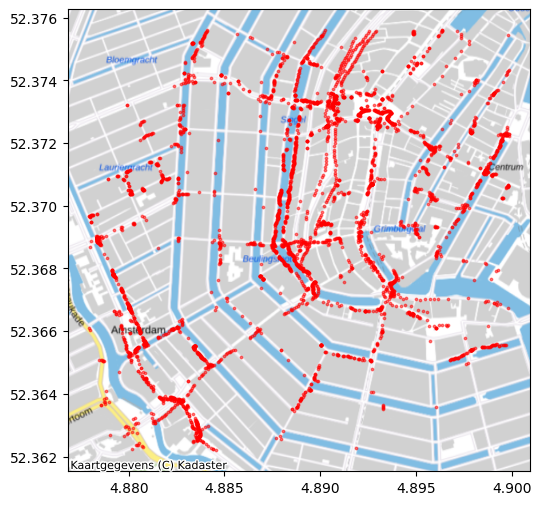

In [ ]:
ax = gdf.plot(column='uuid', color='red', markersize=3, figsize=(6, 6), alpha=0.5)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.standaard)

### 4 - Download images

Next, we will download images for the Amsterdam subset that we created above by using the images sources that we loaded into our workspace. We can download all the images corresponding to a data source in one go. However, the unified API of all image sources requires that the dataset contain two hardwired columns: `source` and `image_id`. This is a design choice to avoid having to handle potentially very different sources. Ibis makes it trivial to remap column names with the `select` method by providing a dictionary with the desired column names as keys and the existing columns that they map to as values.

In [21]:
src_table = ams.select({"source": "source", "image_id": "orig_id"})

Extract the source types in the table. A source must be supported ***and*** loaded in order to be recognised.

In [22]:
source_types = ws.get_source_types_from_table(src_table)
source_types

{<SourceType.KartaView: 'kartaview'>, <SourceType.Mapillary: 'mapillary'>}

Now we are ready to instruct the workspace manager to download the images. We can request only a sample of all the images (useful for initial prototyping and demonstrations like this one). Only missing images will be downloaded.

In [23]:
sample = ws.download_images(src_table, sample=10)

Streetscapes | 2025-04-24@13:54:06 | Reusing an existing Mapillary source, use the replace argument to override.


Peek into the sample.

In [24]:
sample

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ source    ┃ image_id         ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ string    │ int64            │
├───────────┼──────────────────┤
│ Mapillary │ 1088139425387545 │
│ Mapillary │  152168940201063 │
│ Mapillary │  202034728211838 │
│ Mapillary │  316446906741166 │
│ Mapillary │ 3728355877292401 │
│ Mapillary │  133684895407450 │
│ Mapillary │ 4191857767501092 │
│ Mapillary │ 1322554881573136 │
│ Mapillary │  130236095796071 │
│ Mapillary │ 1805441999614990 │
└───────────┴──────────────────┘

Some of the images that we request might not exist any more on the image source. Figure out which images have been downloaded and which ones are missing.

In [25]:
existing, missing = ws.check_image_status(sample)
print(f"==[ existing: {[i.name for e in existing.values() for i in e]}")
print(f"==[ missing: {missing}")

Streetscapes | 2025-04-24@13:54:06 | Reusing an existing Mapillary source, use the replace argument to override.


==[ existing: ['4191857767501092.jpeg', '152168940201063.jpeg', '1322554881573136.jpeg', '202034728211838.jpeg', '130236095796071.jpeg', '1805441999614990.jpeg', '133684895407450.jpeg', '316446906741166.jpeg', '3728355877292401.jpeg', '1088139425387545.jpeg']
==[ missing: {<SourceType.Mapillary: 'mapillary'>: set()}


### 5 - Segment images

We can load various models and apply them to the image data that we have loaded or generated so far. Currently, Streetscapes supports two segmentation models:

- `MaskFormer`: A relatively small and nimble model that recognises objects from a fixed number of categories.
- `DinoSAM`: A combination of two independent models that work together to perform instance segmentation simply by providing a prompt. It is much more flexible than `MaskFormer` in that it recognises *arbitrary categories*; however, it is much slower.

We will segment the images with both models to illustrate their differences. First, we load the models using an API analogous to that for data sources, with the exception that models are spawned globally and can be reused across multiple workspaces since they are workspace-agnostic. This is another design choice to minimise memory consumption for potentially large models.

In [26]:
mf = ws.spawn_model(ModelType.MaskFormer)
ds = ws.spawn_model(ModelType.DinoSAM)

We define the categories of objects that we would like to look for in the images that we are segmenting. Categories are defined hierarchically as a nested dictionary. Subcategories (such as `window` and `door` below) will be identified as separate categories, but the pixels that they occupy will be subtracted from ones attributed to their parent (here, `building`). In this way, it is possible to extract building façades excluding windows and doors. Internally, this nested dictionary is flattened, and any overlaps are handled after instances of the corresponding categories have been identified.

In [27]:
labels = {
    "building": {
        "window": None,
        "door": None,
    },
    "vegetation": None,
    "car": None,
    "truck": None,
    "road": None,
}

Segment all images contained in a dataset. Here, we use our`sample` dataset that we created above. A batch size (defaulting to `10`) can be specified to speed up the segmentation, but here we use a batch size of 1 to show the progress more clearly.

In [28]:
mf_segmentations = ws.segment_from_dataset(sample, mf, labels)

Streetscapes | 2025-04-24@13:54:12 | Reusing an existing Mapillary source, use the replace argument to override.
Done: 100%|██████████| 1/1 [00:34<00:00, 34.66s/it]                          


The masks and the instances are saved as separate files with the same name as the input image but in different formats (NumPy archived arrays and Parquet files, respectively) so that they can be loaded later together. Here, we print the name of the file containing the mask for the first segmented image.

In [29]:
mf_segmentations[0].mask_path.name

'4191857767501092.npz'

Show the categories (out of the ones that we requested) identified by this model.

In [30]:
mf_segmentations[0].get_instance_table().select('label').distinct()

┏━━━━━━━━━━━━┓
┃ label      ┃
┡━━━━━━━━━━━━┩
│ string     │
├────────────┤
│ curb       │
│ sky        │
│ on-rails   │
│ bicycle    │
│ wall       │
│ water      │
│ person     │
│ vegetation │
│ building   │
│ sidewalk   │
└────────────┘

Visualise the parts of the image corresponding to some object categories of interest (here, we ask for everything that is labelled as a `building`).

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

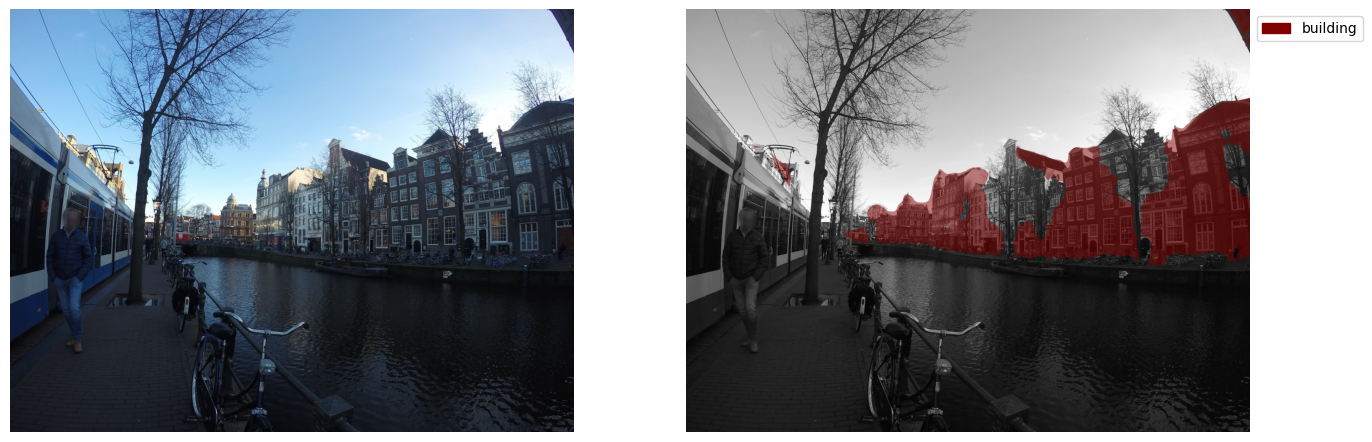

In [31]:
mf_segmentations[0].visualise('building')

If the `visualise()` method is called without an argument, all the identified categories are visualised.

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

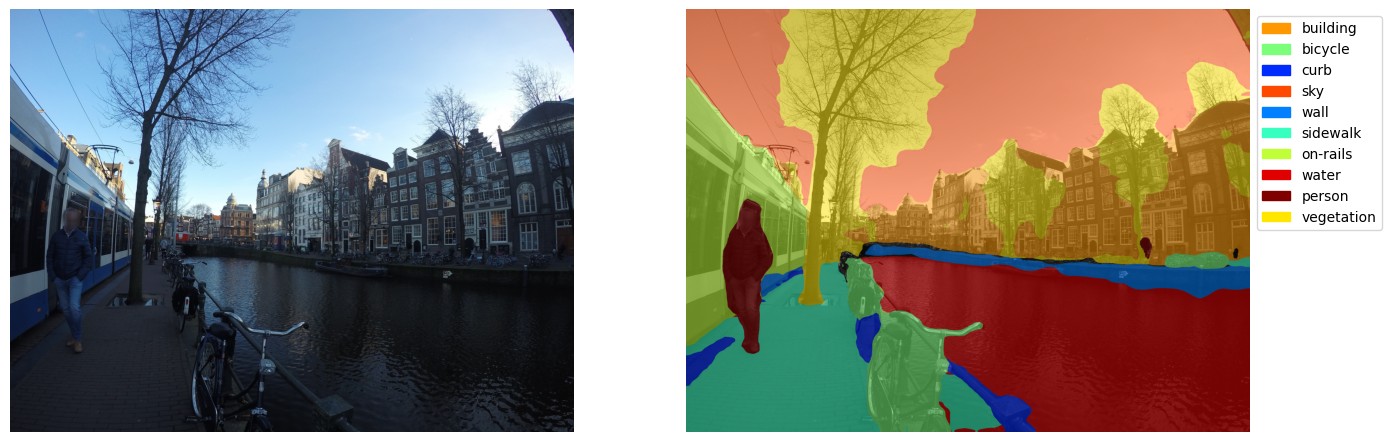

In [32]:
mf_segmentations[0].visualise()

We can also extract instances for individual categories and and visualise them in isolation.

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

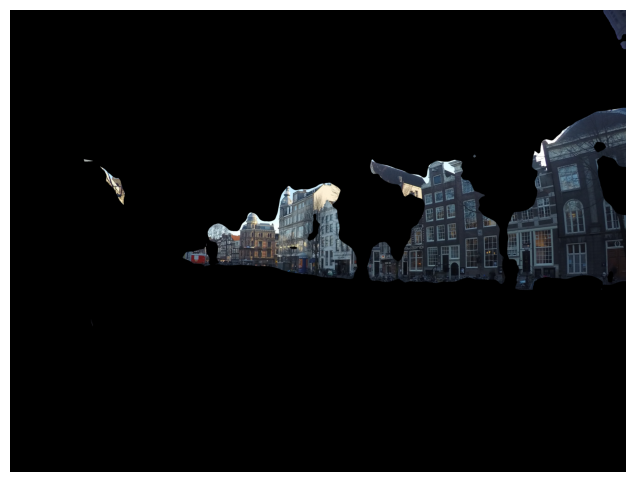

In [33]:
buildings = mf_segmentations[0].get_instances("building")
buildings[0].visualise(mf_segmentations[0].get_image())

We will now execute the same pipeline with the `DinoSAM` model.

In [34]:
ds_segmentations = ws.segment_from_dataset(sample, ds, labels, batch_size=1)

Streetscapes | 2025-04-24@13:54:52 | Reusing an existing Mapillary source, use the replace argument to override.
Done: 100%|██████████| 10/10 [01:16<00:00,  7.66s/it]                          


In [35]:
ds_segmentations[0].get_instance_table().select('label').distinct()

┏━━━━━━━━━━━━┓
┃ label      ┃
┡━━━━━━━━━━━━┩
│ string     │
├────────────┤
│ road       │
│ vegetation │
│ window     │
│ building   │
└────────────┘

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

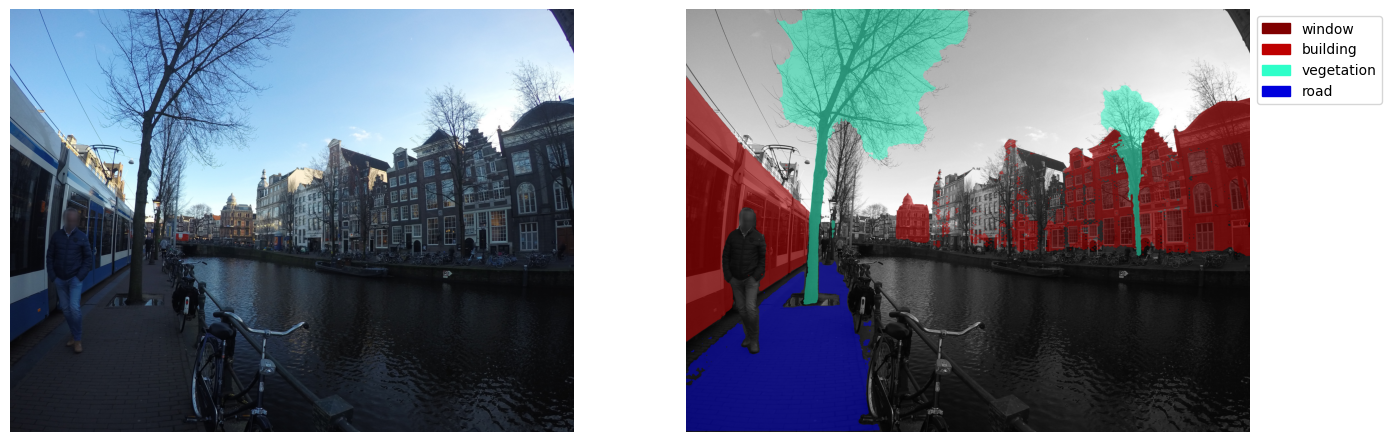

In [36]:
ds_segmentations[0].visualise()

In [37]:
ds_segmentations[0]

Segmentation(mask=/Users/clairedonnelly/.cache/huggingface/assets/streetscapes/images/mapillary/masks/dinosam/4191857767501092.npz

### 6 - Calculate statistics

In [38]:
import numpy as np

image_means = []
for seg in ds_segmentations:
    image = seg.get_image()
    buildings = seg.get_instances("building")
    building_means = []
    for building in buildings:
        # TODO: would be nice to have building.get_mask_3d or something like that
        mask_3d = np.repeat(building.mask[:, :, None], 3, axis=2)
        masked_img = np.ma.masked_array(image, mask=mask_3d)
        building_mean = masked_img.mean()
        building_means.append(building_mean)
    image_mean = np.mean(building_means)
    image_means.append(image_mean)

np.array(image_means)


array([ 96.31751066,  64.04142632,  96.39603582, 109.74897835,
       104.84929986,  80.19360327, 137.89719952,  98.81851441,
       105.17113725,  77.60544618])

In [39]:
# # Wishful code for calculation means

# image_means = []
# for seg in ds_segmentations:
#     image = seg.get_image()
#     buildings = seg.get_instances("building")
#     # TODO: would be nice if we had a utility to directly calculate something on all instances at once
#     building_means = [building.mask_3d.mean() for building in buildings]
#     image_mean = np.mean(building_means)
#     image_means.append(image_mean)

# # Even more streamlined version
# pixel_mean = lambda pixels: pixels.mean
# image_means = [seg.get_all_instances("building").apply(pixel_mean) for seg in ds_segmentations]

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

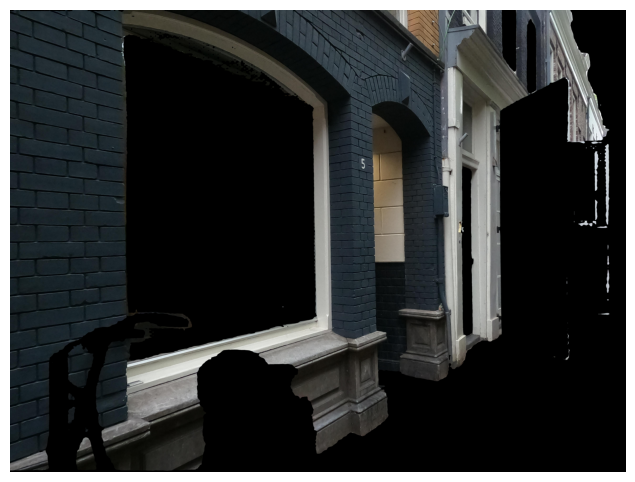

In [40]:
buildings[0].visualise(image)

### 7 - Rasterise data